# HCPUR100 subcortico-subcortical connectivity 

## Modules & Custom Functions <a class="anchor" id="imports"></a>

Every time the notebook is started, the following code cell must be run.

In [1]:
import itertools
import os

import dill
import dipy.io.streamline
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as stats
import seaborn as sns
from dipy.viz import colormap as cmap
from fury import actor, window
from IPython.display import HTML, clear_output
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from mne.viz import circular_layout, plot_connectivity_circle as plot_chord
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

# Set number of processors for multiproccessing
n_proc = 12

# Define a function to handle importing database to avoid rerunning cells
def handle_session(save=False):
    if save:
        print("Saving notebook session")
        dill.dump_session(os.path.realpath("./db/hcpur100_3T_Zona_Connectivity.db"), byref=True)
    else:
        print("Loading notebook session")
        dill.load_session(os.path.realpath("./db/hcpur100_3T_Zona_Connectivity.db"))


# Pandas settings
pd.set_option("display.max_rows", None)

try:
    handle_session()
except:
    raise FileNotFoundError(
        """No database found - please run the all of the following cells to
    set up custom functions and perform analysis"""
    )

/srv/khan/users/tkai/opt/venv/hcp-subcortical-analysis-_mFvww50-py3.8/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Loading notebook session


In [2]:
# Variables
test_dir = os.path.realpath("../../data/hcp1200_3T/hcp_test")
zona_dir = os.path.realpath("../../data/hcpur100_3T")

In [3]:
# Plot settings
# Color friendly color cycle - gist.github.com/thriveth/8560036
cb_color_cycle = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]

cmap = mpl.cm.get_cmap("viridis")
cmap.set_bad("black")
sns.set(
    style="ticks",
    context="poster",
    rc={
        "image.cmap": "viridis",
        "axes.prop_cycle": plt.cycler(color=cb_color_cycle),
        "font.sans-serif": "Liberation Sans",
        "font.monospace": "Liberation Sans",
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "axes.labelweight": "bold",
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    },
)

boxprops = dict(edgecolor="white", alpha=0.5)
whiskerprops = dict(color="black", linestyle="--", alpha=0.5)
capprops = dict(color="black", alpha=0.5)
medianprops = dict(color="white", linewidth=2)
figure_dir = os.path.realpath("./figures")

/tmp/ipykernel_26640/1720697209.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad("black")


In [8]:
def make_mat(vals, mat_size):
    """
    Create a connectivity matrix from an array of sorted array of values

    INPUTS:
        vals - sorted array of values to be added to matrix
        mat_size - size of matrix
    """

    mask = ~np.tri(mat_size, k=0, dtype=bool)
    mat = np.zeros((mat_size, mat_size), dtype=np.float32)
    mat[mask] = vals
    mat.T[mask] = vals

    return mat

In [10]:
def check_hemi(node: int):
    return "Even" if ((node % 2) == 0) else "Odd"

In [18]:
# Scale 3D Plot
from mpl_toolkits.mplot3d.axes3d import Axes3D

def short_proj(ax, x_scale=1., y_scale=1., z_scale=1.):
    scale = np.diag([x_scale, y_scale, z_scale, 1.])
    scale = scale / scale.max()
    scale[3, 3] = 1.
    
    return np.dot(Axes3D.get_proj(ax), scale)

## Demographics <a class="anchor" id="demographics"></a>

In [18]:
# Subjects to remove because of problematic segmentations or
# tractography processing could not be completed due to time
del_subj = [101309, 105115, 144832, 239944, 756055, 792564, 856766, 857263]
del_subj = [f"sub-{subj}" for subj in del_subj]

# Check for repeat subjects and remove them
if not os.path.isfile(f"{zona_dir}/demographics.csv"):
    demographics_df = pd.read_csv(f"{zona_dir}/participants.tsv", delimiter="\t")
    test_df = pd.read_csv(f"/home/ROBARTS/tkai/graham/scratch/Zona/data/hcp1200_3T/participants.tsv", 
                          delimiter="\t", header=None)

    demographics_df = demographics_df[~demographics_df["participant_id"].isin(test_df[0].tolist())]
    
    # Save new list to disk
    demographics_df.to_csv(f"{zona_dir}/demographics.csv", index=None)
    del test_df

demographics_df = pd.read_csv(f"{zona_dir}/demographics.csv")
demographics_df = demographics_df[~demographics_df["participant_id"].isin(del_subj)]
demographics_df = demographics_df.rename(columns={"participant_id": "Subject"})

## Parcellation mapping

List is split into two cells to be able to show full list

In [5]:
parcellation_map = pd.read_csv(
    f"{test_dir}/derivatives/zona_bb_subcortex/code/subcortical-labels.csv"
)

# Grab indices to be evaluated (core network structures)
# Indices for thalamic labels
left_thal = [34, 36, 40, 42, 46, 50, 68]
right_thal = [label+1 for label in left_thal]

# Indices for non-thalamic labels; ignore hippocampus
left_nonthal = [2, 4, 6, 8, 10, 12, 18]
right_nonthal = [label+1 for label in left_nonthal]

# Reindex list
reindex_list = list(
    np.concatenate([left_nonthal, left_thal, right_nonthal, right_thal])
)

# Drop hippocampal labels
parcellation_map = parcellation_map.filter(items=reindex_list, axis=0)
parcellation_map

Label   Hemi                                            Nuclei      Abbrev
2       3   left                             left substantia nigra        L SN
4       5   left                          left subthalamic nucleus       L STN
6       7   left                                      left caudate       L Cau
8       9   left                                      left putamen       L Put
10     11   left                      left globus pallidus externa       L GPe
12     13   left                      left globus pallidus interna       L GPi
18     19   left                                     left amygdala       L Amy
34     35   left                        left thalamus centromedian   L Thal CM
36     37   left            left thalamus ventral lateral anterior  L Thal VLa
40     41   left    left thalamus mediodorsal medial magnocellular  L Thal MDm
42     43   left                      left thalamus parafascicular   L Thal Pf
46     47   left   left thalamus mediodorsal lateral parvocellular  L Thal MDl
50     51   left                    left thalamus ventral anterior   L Thal VA
68     69   left           left thalamus ventral lateral posterior  L Thal VLp
3       4  right                            right substantia nigra        R SN
5       6  right                         right subthalamic nucleus       R STN
7       8  right                                     right caudate       R Cau
9      10  right                                     right putamen       R Put
11     12  right                     right globus pallidus externa       R GPe
13     14  right                     right globus pallidus Interna       R GPi
19     20  right                                    right amygdala       R Amy
35     36  right                       right thalamus centromedian   R Thal CM
37     38  right           right thalamus ventral lateral anterior  R Thal VLa
41     42  right   right thalamus mediodorsal medial magnocellular  R Thal MDm
43     44  right                     right thalamus parafascicular   R Thal Pf
47     48  right  right thalamus mediodorsal lateral parvocellular  R Thal MDl
51     52  right                   right thalamus ventral anterior   R Thal VA
69     70  right          right thalamus ventral lateral posterior  R Thal VLp

## Subcortical Analysis <a class="anchor" id="analysis"></a>

### HCPUR100 3T Dataset <a class="anchor" id="test_analysis"></a>

In [19]:
# Read in subject and node data
for subjIdx, subj in enumerate(tqdm(demographics_df["Subject"].tolist())):
    subj = f"{subj}"
    csv_file = f"{zona_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subj}/tractography/{subj}_space-dwi_desc-subcortical_nodeweights.csv"

    if subjIdx == 0:
        hcpur_conn_mat = np.genfromtxt(csv_file, delimiter=" ")
        hcpur_conn_mat = hcpur_conn_mat[:, :, np.newaxis]
    else:
        temp_mat = np.genfromtxt(csv_file, delimiter=" ")
        temp_mat = temp_mat[:, :, np.newaxis]
        hcpur_conn_mat = np.append(hcpur_conn_mat, temp_mat, axis=2)

100%|███████████████████████████████████████████| 85/85 [00:00<00:00, 88.21it/s]


#### Individual subjects

  0%|                                                    | 0/85 [00:00<?, ?it/s]/tmp/ipykernel_13113/3458015915.py:10: RuntimeWarning: divide by zero encountered in log10
  np.log10(df_test_subj),
100%|███████████████████████████████████████████| 85/85 [00:33<00:00,  2.53it/s]


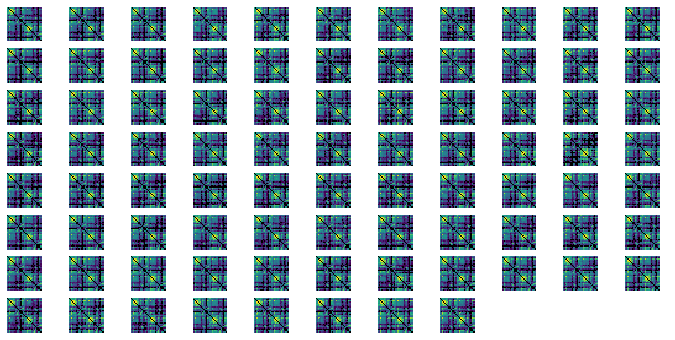

In [22]:
f, ax = plt.subplots(8, 11, figsize=(12, 6))

for s in tqdm(range(len(demographics_df["Subject"].tolist()))):
    df_test_subj = pd.DataFrame(hcpur_conn_mat[:, :, s])
    df_test_subj = df_test_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
    df_test_subj = df_test_subj.reindex(index=reindex_list, columns=reindex_list)

    # Plot
    sns.heatmap(
        np.log10(df_test_subj),
        ax=ax[int(s / 11)][s % 11],
        cmap="viridis",
        vmin=-1,
        vmax=4,
        square=True,
        cbar=None,
    )

    ax[int(s / 11)][s % 11].tick_params(axis="both", length=0)
    ax[int(s / 11)][s % 11].set_xticklabels("", va="top", ha="center")
    ax[int(s / 11)][s % 11].set_yticklabels("", rotation=0, va="top", ha="right")
    
for ax_i in range(8, 11):
    ax[7][ax_i].set_axis_off()

plt.show()
plt.close()

/tmp/ipykernel_13113/3415718651.py:10: RuntimeWarning: divide by zero encountered in log10
  np.log10(df_hcpur_subj),


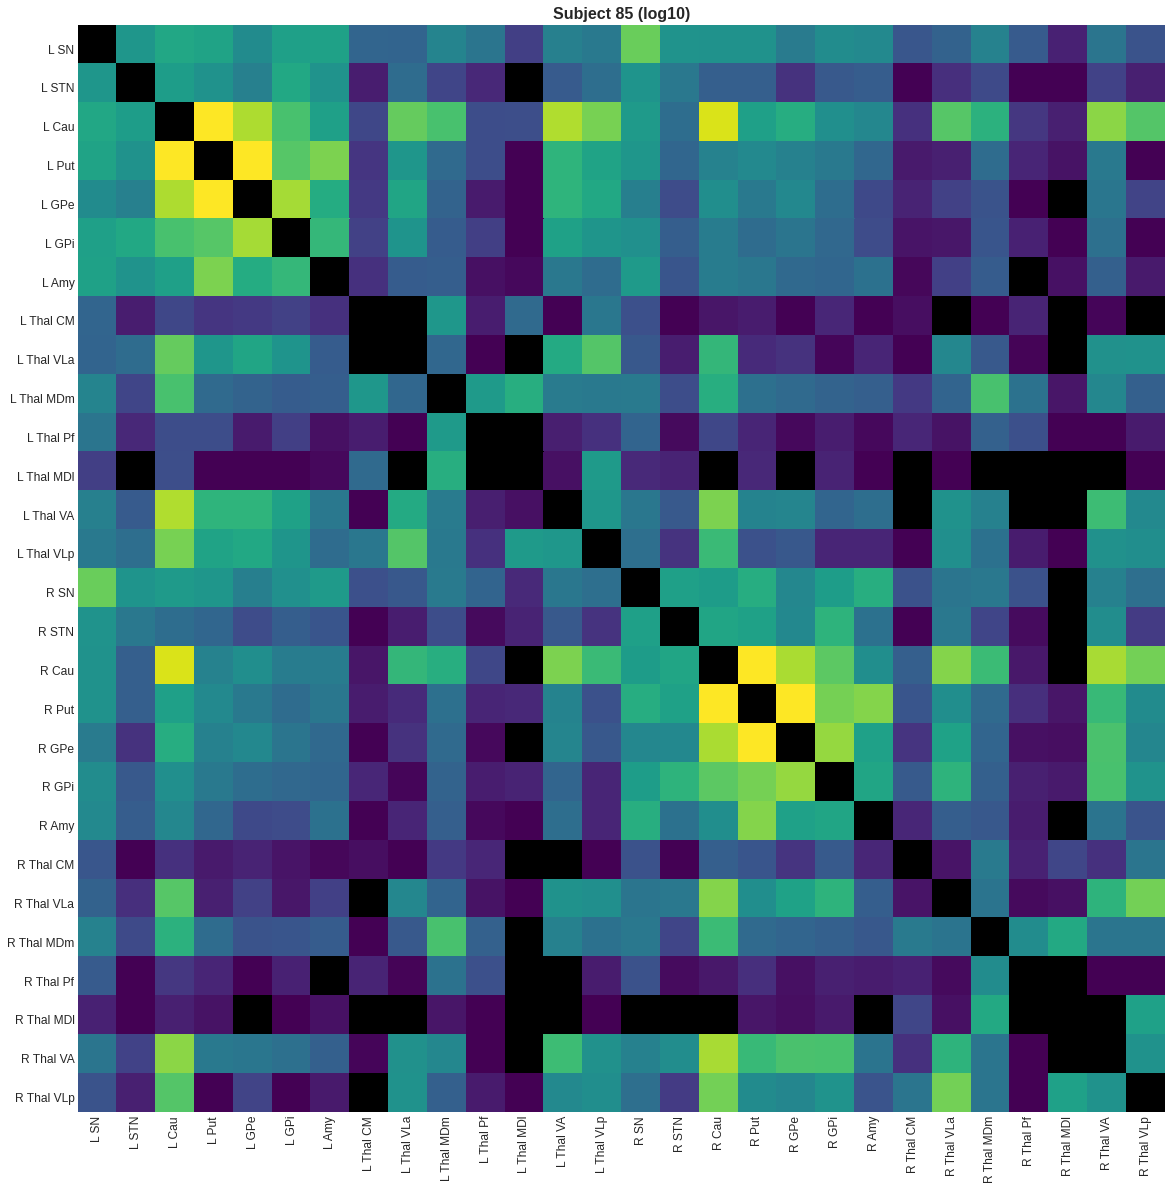

In [23]:
# Animation of individual subjects
def update(i):
    df_hcpur_subj = pd.DataFrame(hcpur_conn_mat[:, :, i])
    df_hcpur_subj = df_hcpur_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

    # Reorganize dataframe by hemisphere
    df_hcpur_subj = df_hcpur_subj.reindex(index=reindex_list, columns=reindex_list)

    graph = sns.heatmap(
        np.log10(df_hcpur_subj),
        ax=ax,
        cmap="viridis",
        vmin=-1,
        vmax=4,
        square=True,
        cbar=False,
    )

    ax.set_title("Subject {0} (log10)".format(i + 1))
    ax.set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=90,
        va="top",
        ha="center",
    )
    ax.set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=0,
        va="top",
        ha="right",
    )

    return (graph,)


fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.tick_params(axis="both", length=0)
ax.set_xticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax.set_xticklabels(
    parcellation_map.reindex(index=reindex_list)["Abbrev"],
    rotation=90,
    va="top",
    ha="center",
)
ax.set_yticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax.set_yticklabels(
    parcellation_map.reindex(index=reindex_list)["Abbrev"],
    rotation=0,
    va="top",
    ha="right",
)

ani = FuncAnimation(
    fig, update, frames=hcpur_conn_mat.shape[2], interval=200, repeat=True
)

filename = f"{figure_dir}/test_subj_streamline_weight.gif"
# ani.save(filename, writer="imagemagick", fps=1)

HTML(ani.to_html5_video())

In [24]:
plt.close()

#### Group stats

In [25]:
hcpur_conn_avgmat = np.nanmean(hcpur_conn_mat, axis=2)
hcpur_conn_stdmat = np.nanstd(hcpur_conn_mat, axis=2)
hcpur_conn_covmat = hcpur_conn_stdmat / hcpur_conn_avgmat

df_hcpur_avg_subconn = pd.DataFrame(hcpur_conn_avgmat)
df_hcpur_avg_subconn = df_hcpur_avg_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

df_hcpur_std_subconn = pd.DataFrame(hcpur_conn_stdmat)
df_hcpur_std_subconn = df_hcpur_std_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

df_hcpur_cov_subconn = pd.DataFrame(hcpur_conn_covmat)
df_hcpur_cov_subconn = df_hcpur_cov_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

# Add hemisphere and nuclei information
df_hcpur_avg_subconn["nuclei"] = df_hcpur_std_subconn["nuclei"] = df_hcpur_cov_subconn[
    "nuclei"
] = parcellation_map["Abbrev"]

# Reorganize dataframe by hemisphere
df_hcpur_avg_subconn = df_hcpur_avg_subconn.reindex(
    index=reindex_list, columns=reindex_list
)
df_hcpur_std_subconn = df_hcpur_std_subconn.reindex(
    index=reindex_list, columns=reindex_list
)
df_hcpur_cov_subconn = df_hcpur_cov_subconn.reindex(
    index=reindex_list, columns=reindex_list
)

/tmp/ipykernel_13113/3699479018.py:3: RuntimeWarning: invalid value encountered in true_divide
  hcpur_conn_covmat = hcpur_conn_stdmat / hcpur_conn_avgmat


/tmp/ipykernel_13113/3746056418.py:9: RuntimeWarning: divide by zero encountered in log10
  np.log10(df_hcpur_avg_subconn),
/tmp/ipykernel_13113/3746056418.py:22: RuntimeWarning: divide by zero encountered in log10
  np.log10(df_hcpur_std_subconn),


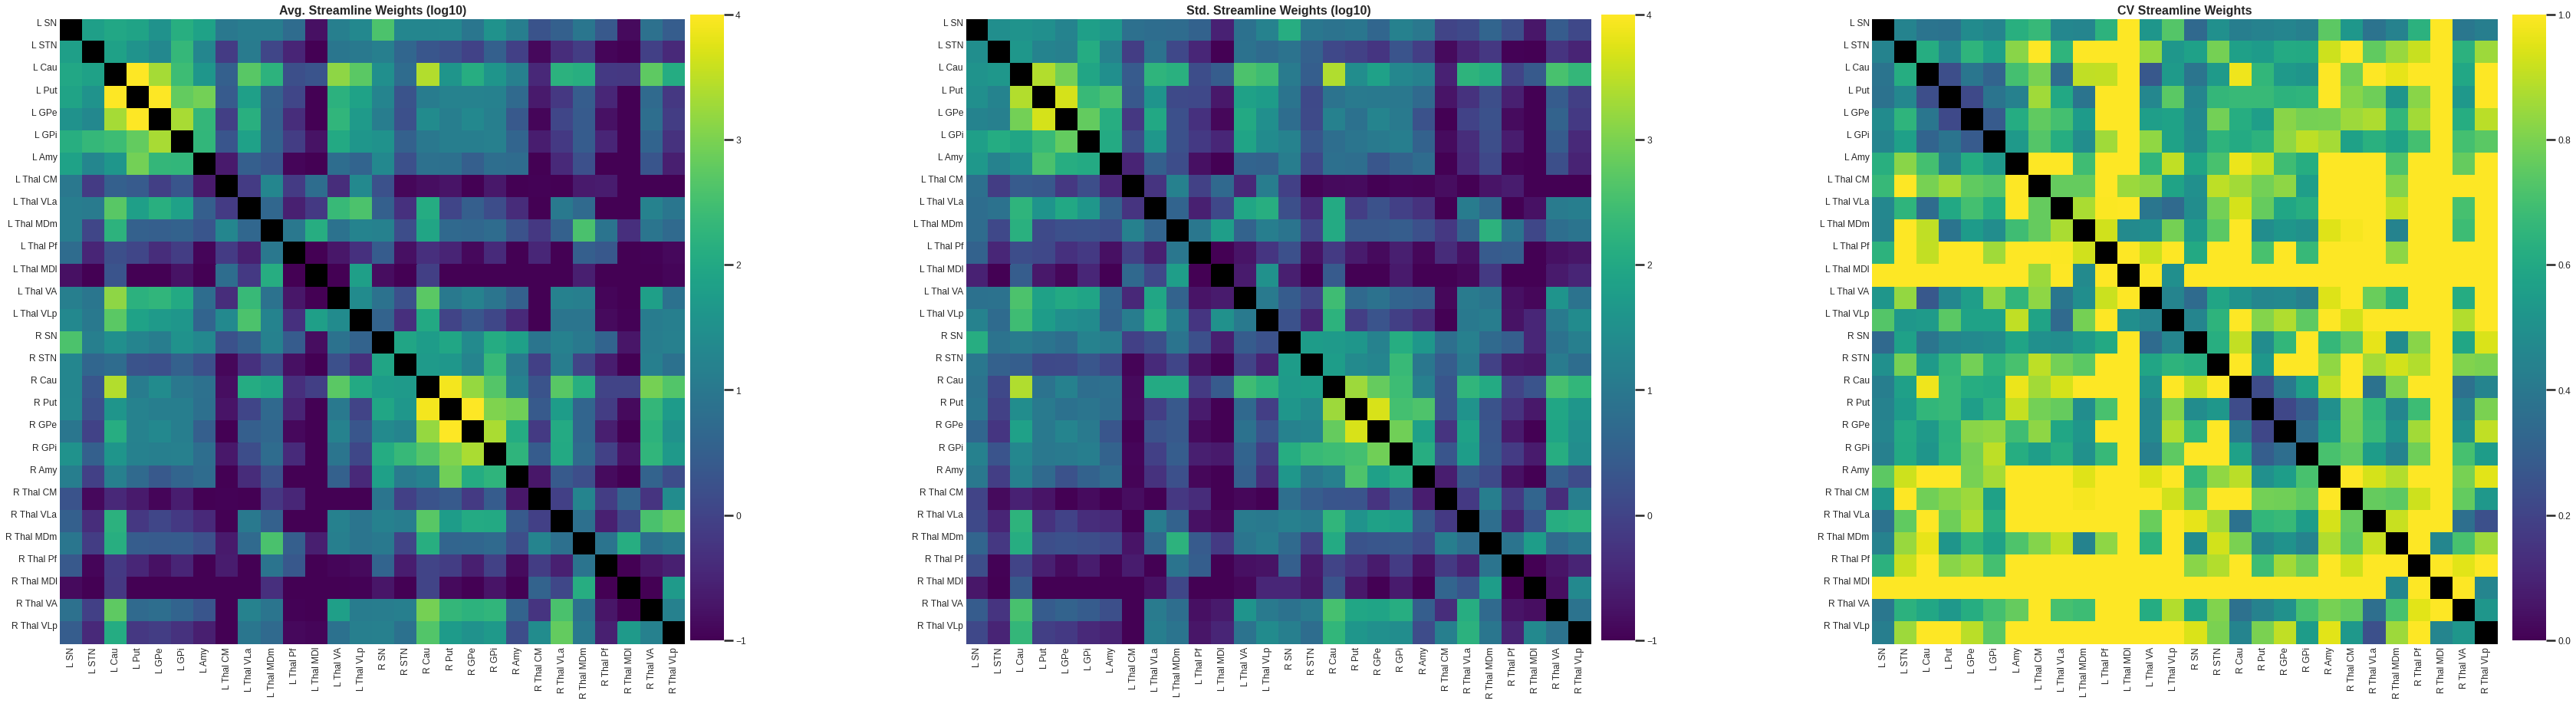

In [26]:
# Plot group stats
%matplotlib inline

f, ax = plt.subplots(1, 3, figsize=(60, 15))

# Average
cbar_ax1 = f.add_axes([0.335, 0.13, 0.01, 0.755])
sns.heatmap(
    np.log10(df_hcpur_avg_subconn),
    ax=ax[0],
    cmap="viridis",
    vmin=-1,
    vmax=4,
    square=True,
    cbar_ax=cbar_ax1,
)
ax[0].set_title("Avg. Streamline Weights (log10)")

# Standard Deviation
cbar_ax2 = f.add_axes([0.610, 0.13, 0.01, 0.755])
sns.heatmap(
    np.log10(df_hcpur_std_subconn),
    ax=ax[1],
    cmap="viridis",
    vmin=-1,
    vmax=4,
    square=True,
    cbar_ax=cbar_ax2,
)
ax[1].set_title("Std. Streamline Weights (log10)")

# COV
cbar_ax3 = f.add_axes([0.885, 0.13, 0.01, 0.755])
sns.heatmap(
    df_hcpur_cov_subconn,
    ax=ax[2],
    cmap="viridis",
    vmin=0,
    vmax=1,
    square=True,
    cbar_ax=cbar_ax3,
)
ax[2].set_title("CV Streamline Weights")

# Labels
for d in range(3):
    ax[d].tick_params(axis="both", length=0)
    ax[d].set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"], va="top", ha="center",
        rotation=90
    )
    ax[d].set_yticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"]))
    )
    ax[d].set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=0,
        va="top",
        ha="right",
    )

filename = "{0}/hcpur_avg_streamline_weights.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [27]:
# CV for all connections
hcpur_avg = df_hcpur_avg_subconn
hcpur_avg = hcpur_avg.replace(0, np.nan)
hcpur_avg = hcpur_avg.where(np.triu(np.ones(hcpur_avg.shape), k=1).astype(np.bool))
hcpur_avg = hcpur_avg.values.flatten()
hcpur_avg = hcpur_avg[np.logical_not(np.isnan(hcpur_avg))]

hcpur_cv = df_hcpur_cov_subconn
hcpur_cv = hcpur_cv.where(np.triu(np.ones(hcpur_cv.shape), k=1).astype(np.bool))
hcpur_cv = hcpur_cv.values.flatten()
hcpur_cv = hcpur_cv[np.logical_not(np.isnan(hcpur_cv))]

df_hcpur_cv_vs_avg = pd.DataFrame(
    {"CV": hcpur_cv, "Avg": hcpur_avg, "Avg (log)": np.log10(hcpur_avg)}
)
df_hcpur_cv_vs_avg.sort_values(by=["CV"], inplace=True, ascending=False)

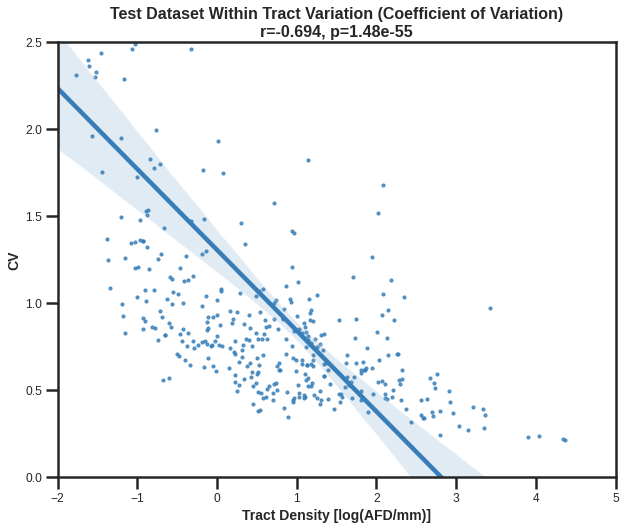

In [28]:
# Plot all CV
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.regplot(
    x="Avg (log)",
    y="CV",
    data=df_hcpur_cv_vs_avg,
    ax=ax,
    ci=95,
    scatter_kws={"s": 10},
)

pstats = stats.spearmanr(df_hcpur_cv_vs_avg["Avg (log)"], df_hcpur_cv_vs_avg["CV"])


ax.set_title(
    f"""Test Dataset Within Tract Variation (Coefficient of Variation)
r={pstats[0]:.3f}, p={pstats[1]:.3g}"""
)
ax.set_xlabel("Tract Density [log(AFD/mm)]")
ax.set_ylim([0, 2.5])
ax.set_xlim([-2, 5])

filename = "{0}/test_all_cv.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [29]:
plt.close()

#### Averaged stats

In [30]:
# Create data frame
df_hcpur = pd.DataFrame(np.nanmean(hcpur_conn_mat, axis=2))
df_hcpur = df_hcpur.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
df_hcpur = df_hcpur.replace(0, np.nan)

# Add labels
df_hcpur["hemi"] = parcellation_map["Hemi"]
df_hcpur["nuclei"] = parcellation_map["Nuclei"]

# Reorganize by hemi
df_hcpur.sort_values(by=["nuclei"], inplace=True)
temp_list = df_hcpur.index.tolist()
temp_list.append("hemi")
temp_list.append("nuclei")
df_hcpur.sort_values(by=["nuclei"], inplace=True)
df_hcpur = df_hcpur.reindex(columns=temp_list)

# Get hemispheric connections
hcpur_vals = []

hcpur_left = df_hcpur.iloc[0:7, 0:7].to_numpy()[np.triu_indices(7, k=1)]
hcpur_left = np.append(hcpur_left, df_hcpur.iloc[0:7, 7:14].to_numpy().flatten())
hemi = ["Left" for i in range(len(hcpur_left))]
hcpur_vals = np.append(hcpur_vals, hcpur_left)

hcpur_right = df_hcpur.iloc[14:21, 14:21].to_numpy()[np.triu_indices(7, k=1)]
hcpur_right = np.append(hcpur_right, df_hcpur.iloc[14:21, 21:28].to_numpy().flatten())

hemi = np.append(hemi, ["Right" for i in range(len(hcpur_right))])
hcpur_vals = np.append(hcpur_vals, hcpur_right)

# Create dataframe to store data for plotting
df_hcp_core = pd.DataFrame(
    {
        "HCPUR": np.log10(hcpur_vals),
        "Density": np.log10(np.nanmean(np.array([hcpur_vals]), axis=0)),
        "Hemi": hemi,
    }
)

del (
    df_hcpur,
    temp_list,
    hemi,
    hcpur_left,
    hcpur_vals,
    hcpur_right,
)

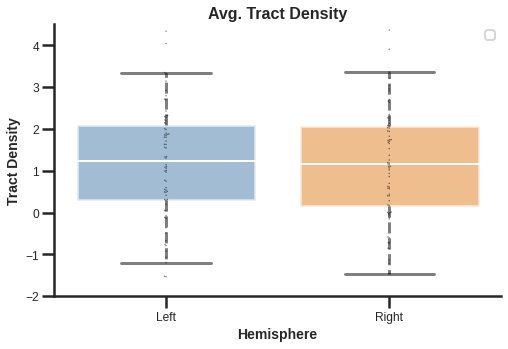

In [35]:
# Plot hemispheric differences
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(
    data=df_hcp_core,
    x="Hemi",
    y="Density",
    dodge=True,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    showfliers=False,
    whis=0.95,
)
sns.swarmplot(
    data=df_hcp_core,
    x="Hemi",
    y="Density",
    color="black",
    alpha=0.5,
    dodge=True,
    size=1.5,
)

ax.set_ylim([-2, 4.5])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.title("Avg. Tract Density")
plt.ylabel("Tract Density")
plt.xlabel("Hemisphere")

# filename = f"{figure_dir}/percent_diff_by_hemi.png"
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

# del df

#### In-depth subcortical nodes

* Iterate over subjects

In [61]:
df_subconn = dict()
df_subconn["Subject"] = []
df_subconn["Hemi"] = []
df_subconn["Nodes"] = []
df_subconn["HCPUR Density"] = []
df_subconn["HCPUR Density [log10]"] = []

# Compute for nodes
for idx, (node1, node2) in enumerate(
    tqdm(list(itertools.combinations(parcellation_map["Label"].tolist(), 2)))
):
    nodes = f"{node1}-{node2}"
    # Check for hemi
    if check_hemi(node1) == check_hemi(node2) == "Even":
        hemi = "R"
    elif check_hemi(node1) == check_hemi(node2) == "Odd":
        hemi = "L"
    else:
        hemi = "Inter"

    for s, subj in enumerate(demographics_df["Subject"].tolist()):
        df_subconn["Subject"].append(subj)
        df_subconn["Hemi"].append(hemi)
        df_subconn["Nodes"].append(nodes)

        # Test
        df_hcpur_subj = pd.DataFrame(hcpur_conn_mat[:, :, s])
        hcpur_density = df_hcpur_subj.loc[node1 - 1, node2 - 1]
        df_subconn["HCPUR Density"].append(hcpur_density)
        df_subconn["HCPUR Density [log10]"].append(
            np.log10(df_subconn["HCPUR Density"][-1])
        )

        del (
            df_hcpur_subj,
        )

    clear_output(wait=True)

df_subconn = pd.DataFrame(df_subconn)

# handle_session(save=True)

100%|█████████████████████████████████████████| 378/378 [00:05<00:00, 71.77it/s]


#### ROI metrics

In [32]:
df_rois = dict()
df_rois["Subject"] = []
df_rois["Label"] = []
df_rois["Size (mm^3)"] = []

for subj in tqdm(demographics_df["Subject"].values):
    subj = f"{subj}"

    # Load segmentations
    # Voxel size -
    subj_rois = nib.load(
        f"{zona_dir}/derivatives/zona_bb_subcortex/{subj}/anat/{subj}_space-T1w_desc-ZonaBBSubCorSeg.nii.gz"
    )
    vox_size = subj_rois.header.get_zooms()
    subj_rois = subj_rois.get_fdata()

    for label in parcellation_map["Label"].tolist():
        roi = subj_rois == label
        roi_size = np.round(roi.sum() * vox_size[0] * vox_size[1] * vox_size[2], 3)

        df_rois["Subject"].append(subj)
        df_rois["Label"].append(label)
        df_rois["Size (mm^3)"].append(roi_size)

df_rois = pd.DataFrame(df_rois)
del roi, subj_rois, vox_size

100%|███████████████████████████████████████████| 85/85 [02:19<00:00,  1.64s/it]


In [62]:
df_subconn["Node 1 Size"] = np.nan
df_subconn["Node 2 Size"] = np.nan

for idx, row in tqdm(df_subconn.iterrows()):
    df_subconn.at[idx, "Node 1 Size"] = df_rois[
        (df_rois["Subject"] == f'{df_subconn.loc[idx, "Subject"]}')
        & (df_rois["Label"] == int(df_subconn.loc[idx, "Nodes"].split("-")[0]))
    ]["Size (mm^3)"].values
    df_subconn.at[idx, "Node 2 Size"] = df_rois[
        (df_rois["Subject"] == f'{df_subconn.loc[idx, "Subject"]}')
        & (df_rois["Label"] == int(df_subconn.loc[idx, "Nodes"].split("-")[1]))
    ]["Size (mm^3)"].values[0]

df_subconn["Node 1 Size [log]"] = np.log10(df_subconn["Node 1 Size"])
df_subconn["Node 2 Size [log]"] = np.log10(df_subconn["Node 2 Size"])

handle_session(save=True)

32130it [00:52, 614.36it/s]


Saving notebook session


In [63]:
from statsmodels.formula.api import ols

df = df_subconn.copy()
df = df[df["HCPUR Density"] != 0]
df = df.rename(columns={"HCPUR Density [log10]":"HCPDensity", "Node 1 Size [log]":"Node1Size", "Node 2 Size [log]":"Node2Size"})

results = ols("HCPDensity ~ Node1Size + Node2Size", data=df.dropna()).fit()
ols_params = results.params

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HCPDensity   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     4305.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:25:35   Log-Likelihood:                -41527.
No. Observations:               28477   AIC:                         8.306e+04
Df Residuals:                   28474   BIC:                         8.309e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6729      0.048    -76.915      0.000      -3.767      -3.579
Node1Size      0.7456      0.012     63.971      0.000       0.723       0.768
Node2Size      0.8527      0.012     69.042      0.000       0.828       0.877
==============================================================================
Omnibus:                      386.978   Durbin-Watson:                   0.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.524
Skew:                           0.136   Prob(JB):                     8.99e-61
Kurtosis:                       2.601   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
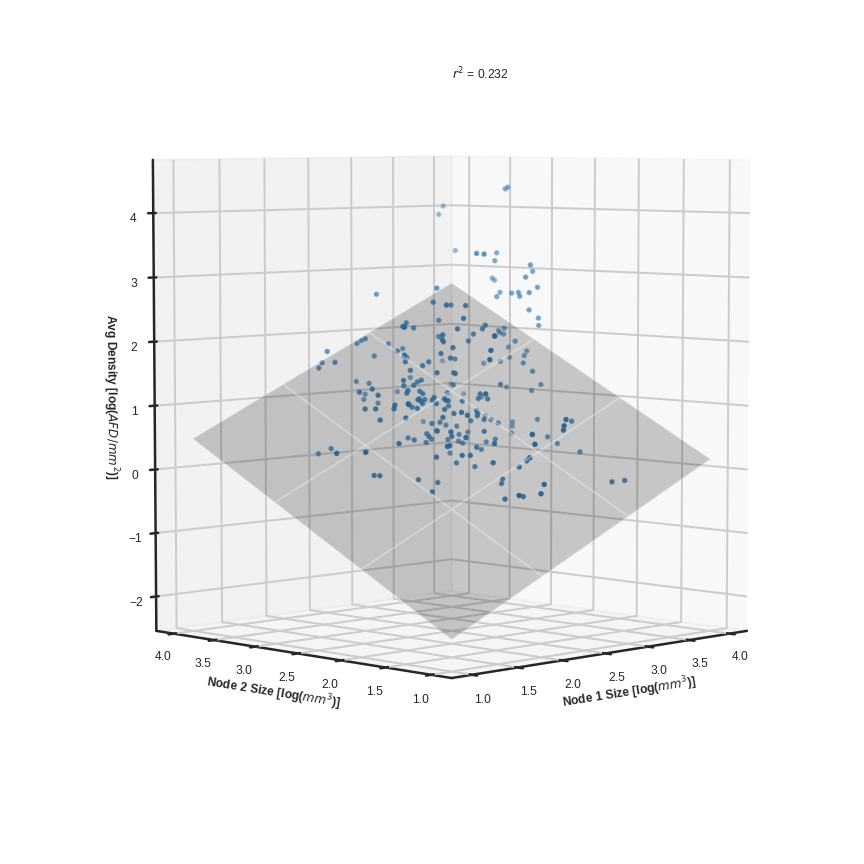

In [74]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fontsize=12

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1, 1, 1, projection="3d")

xx, yy = np.meshgrid(range(1, 5), range(1, 5))
zz = ols_params[0] + xx * ols_params[1] + yy * ols_params[2]

# Get values
x = df_subconn.groupby("Nodes").mean()["Node 1 Size [log]"]
y = df_subconn.groupby("Nodes").mean()["Node 2 Size [log]"]
z = df_subconn.groupby("Nodes").mean()["HCPUR Density [log10]"]
# Plot
ax1.view_init(5, 225)
ax1.scatter(x, y, z, c=cb_color_cycle[0], s=12)
ax1.plot_surface(xx, yy, zz, alpha=0.2, edgecolor=None, color="black")
ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([1., 1., 1.5, 1.]))
# Labels
ax1.set_xlabel("Node 1 Size [log($mm^3$)]", fontsize=fontsize)
ax1.set_ylabel("Node 2 Size [log($mm^3$)]", fontsize=fontsize)
ax1.set_zlabel("Avg Density [log($AFD/mm^2$)]", fontsize=fontsize)
ax1.text(0, 0, 6, f"$r^2$ = {results.rsquared_adj:.3f}", fontsize=fontsize)

plt.show()
plt.savefig(f"{figure_dir}/roi_correlation.svg", dpi=300, bbox_inches="tight", facecolor="white")
# plt.close()

In [66]:
plt.close()

### UR100 vs Test-Retest

#### Correlation

In [43]:
# Load in average tract density matrices for correlation
test_conn_mat = np.load("../hcp1200_3T/db/test_conn_mat.npy")
retest_conn_mat = np.load("../hcp1200_3T/db/retest_conn_mat.npy")

##### Across subjects

##### Averages

In [94]:
test_conn_avgmat = np.nanmean(test_conn_mat, axis=2); test_conn_df = pd.DataFrame(test_conn_avgmat)
retest_conn_avgmat = np.nanmean(retest_conn_mat, axis=2); retest_conn_df = pd.DataFrame(retest_conn_avgmat)
hcpur_conn_avgmat = np.nanmean(hcpur_conn_mat, axis=2); hcpur_conn_df = pd.DataFrame(hcpur_conn_avgmat)

test_conn_df = test_conn_df.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
test_conn_df = test_conn_df.reindex(index=reindex_list, columns=reindex_list)
retest_conn_df = retest_conn_df.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
retest_conn_df = retest_conn_df.reindex(index=reindex_list, columns=reindex_list)
hcpur_conn_df = hcpur_conn_df.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
hcpur_conn_df = hcpur_conn_df.reindex(index=reindex_list, columns=reindex_list)

test_conn_avgmat = test_conn_df.to_numpy()
test_conn_td = [test_conn_avgmat[i][j] for i in delong_conn_idx1 for j in delong_conn_idx2]
retest_conn_avgmat = retest_conn_df.to_numpy()
retest_conn_td = [retest_conn_avgmat[i][j] for i in delong_conn_idx1 for j in delong_conn_idx2]
hcpur_conn_avgmat = hcpur_conn_df.to_numpy()
hcpur_conn_td = [hcpur_conn_avgmat[i][j] for i in delong_conn_idx1 for j in delong_conn_idx2]

# urtest_avg_corr = stats.pearsonr(hcpur_conn_avgmat.flatten(), test_conn_avgmat.flatten())
# urretest_avg_corr = stats.pearsonr(hcpur_conn_avgmat.flatten(), retest_conn_avgmat.flatten())
urtest_avg_corr = stats.pearsonr(hcpur_conn_td, test_conn_td)
urretest_avg_corr = stats.pearsonr(hcpur_conn_td, retest_conn_td)
testretest_avg_corr = stats.pearsonr(test_conn_td, retest_conn_td)

print(f"Correlation of average tract densities between HCPUR100 and HCP Test: r = {urtest_avg_corr[0]}, p = {urtest_avg_corr[1]}")
print(f"Correlation of average tract densities between HCPUR100 and HCP Retest: r = {urretest_avg_corr[0]}, p = {urretest_avg_corr[1]}")
print(f"Correlation of average tract densities between HCPTest and HCP Retest: r = {testretest_avg_corr[0]}, p = {testretest_avg_corr[1]}")

del test_conn_df, retest_conn_df, hcpur_conn_df

Correlation of average tract densities between HCPUR100 and HCP Test: r = 0.9988801092590881, p = 5.061905566980198e-259
Correlation of average tract densities between HCPUR100 and HCP Retest: r = 0.999208915044331, p = 1.1714030180549668e-273
Correlation of average tract densities between HCPTest and HCP Retest: r = 0.9996845847840798, p = 2.200374628694e-312


#### Motor Circuit (Delong)

In [7]:
# Compute ROC curves
# Map nodes in left hemi (parc_map_idx, circuit_map_l_idx, circuit_map_r_idx
node_map = {"SN": (3, 0, 27), "STN": (5, 1, 26), "Caudate": (7, 2, 25), "Putamen": (9, 3, 24), 
            "GPe": (11, 4, 23), "GPi": (13, 5, 22), "Amygdala": (19, 6, 21), 
            "Thal CM": (35, 7, 20), "Thal VLa": (37, 8, 19), "Thal MDmc": (41, 9, 18), "Thal Pf": (43, 10, 17), 
            "Thal MDpc": (47, 11, 16), "Thal VA": (51, 12, 15), "Thal VLp": (69, 13, 14)}
l_node_names = [f"L {node}" for node in node_map.keys()]
r_node_names = [f"R {node}" for node in reversed(node_map.keys())]
final_node_names = l_node_names + r_node_names
del l_node_names, r_node_names


# TP connections 
delong_conn = ["SN-Putamen", "STN-GPe", "STN-GPi", "Putamen-GPe", "Putamen-GPi", "Putamen-Thal CM", "Putamen-Thal Pf", "GPi-Thal VLa", "GPi-Thal VLp"]
delong_idx = []
for conn in delong_conn:
    node1, node2 = conn.split("-")
    delong_idx.append((node_map[node1][1], node_map[node2][1]))
    delong_idx.append((node_map[node1][2], node_map[node2][2]))
    

# Get connectivity of all motor network nodes
all_delong_l_conn, all_delong_r_conn = [], []
all_delong_l_idx, all_delong_r_idx = [], []
delong_all_nodes = ['SN', 'STN', 'Putamen', 'GPe', 'GPi', 'Thal CM', 'Thal VLa', 'Thal Pf', 'Thal VLp']
for conn in itertools.combinations(delong_all_nodes, 2):
    all_delong_l_conn.append(f"{str(node_map[conn[0]][0])}-{str(node_map[conn[1]][0])}")
    all_delong_l_idx.append((node_map[conn[0]][1], node_map[conn[1]][1]))
    all_delong_r_conn.append(f"{str(node_map[conn[0]][0]+1)}-{str(node_map[conn[1]][0]+1)}")
    all_delong_r_idx.append((node_map[conn[0]][2], node_map[conn[1]][2]))
all_delong_conn = all_delong_l_conn + all_delong_r_conn
all_delong_idx = all_delong_l_idx + all_delong_r_idx

# Get TDs
motor_conn_ur_density = np.asarray(
    [df_subconn[df_subconn["Nodes"] == node]["HCPUR Density"].mean() for node in all_delong_conn]
)

# Create all square matrix
motor_mat_density_ur_fp = np.zeros((len(final_node_names), len(final_node_names)))
motor_mat_density_ur_tp = motor_mat_density_ur_fp.copy()
for j, idxes in enumerate(all_delong_idx):
    if idxes in delong_idx:
        motor_mat_density_ur_tp[idxes[0], idxes[1]] = motor_mat_density_ur_tp[idxes[1], idxes[0]] = np.log10(motor_conn_ur_density[j])
    else:
        # Skip intrathalamic
        if (7 <= idxes[0] <= 13 and 7 <= idxes[1] <= 13) or (14 <= idxes[0] <= 20 and 14 <= idxes[1] <= 20):
            motor_mat_density_ur_fp[idxes[0], idxes[1]] = motor_mat_density_ur_fp[idxes[1], idxes[0]] = np.nan
        else:
            motor_mat_density_ur_fp[idxes[0], idxes[1]] = motor_mat_density_ur_fp[idxes[1], idxes[0]] = np.log10(motor_conn_ur_density[j])

motor_mat_density_ur_tp[motor_mat_density_ur_tp == -np.inf] = np.nan
motor_mat_density_ur_tp[motor_mat_density_ur_tp == 0] = np.nan
motor_mat_density_ur_fp[motor_mat_density_ur_fp == -np.inf] = np.nan
motor_mat_density_ur_fp[motor_mat_density_ur_fp == 0] = np.nan

#### Associative Circuit

In [10]:
# Compute ROC curves
# Map nodes in left hemi (parc_map_idx, circuit_map_l_idx, circuit_map_r_idx
node_map = {"SN": (3, 0, 27), "STN": (5, 1, 26), "Caudate": (7, 2, 25), "Putamen": (9, 3, 24), 
            "GPe": (11, 4, 23), "GPi": (13, 5, 22), "Amygdala": (19, 6, 21), 
            "Thal CM": (35, 7, 20), "Thal VLa": (37, 8, 19), "Thal MDmc": (41, 9, 18), "Thal Pf": (43, 10, 17), 
            "Thal MDpc": (47, 11, 16), "Thal VA": (51, 12, 15), "Thal VLp": (69, 13, 14)}
l_node_names = [f"L {node}" for node in node_map.keys()]
r_node_names = [f"R {node}" for node in reversed(node_map.keys())]
final_node_names = l_node_names + r_node_names
del l_node_names, r_node_names

# TP connections 
assoc_conn = ["STN-GPe", "STN-GPi", "Caudate-GPe", "Caudate-GPi", "Putamen-GPe", "GPe-GPi", "GPi-Thal VA"]
assoc_idx = []
for conn in assoc_conn:
    node1, node2 = conn.split("-")
    assoc_idx.append((node_map[node1][1], node_map[node2][1]))
    assoc_idx.append((node_map[node1][2], node_map[node2][2]))

# Get connectivity of all associate network nodes
all_assoc_l_conn, all_assoc_r_conn = [], []
all_assoc_l_idx, all_assoc_r_idx = [], []
assoc_all_nodes = ['STN', 'Caudate', 'Putamen', 'GPe', 'GPi', 'Thal VA']
for conn in itertools.combinations(assoc_all_nodes, 2):
    all_assoc_l_conn.append(f"{str(node_map[conn[0]][0])}-{str(node_map[conn[1]][0])}")
    all_assoc_l_idx.append((node_map[conn[0]][1], node_map[conn[1]][1]))
    all_assoc_r_conn.append(f"{str(node_map[conn[0]][0]+1)}-{str(node_map[conn[1]][0]+1)}")
    all_assoc_r_idx.append((node_map[conn[0]][2], node_map[conn[1]][2]))
all_assoc_conn = all_assoc_l_conn + all_assoc_r_conn
all_assoc_idx = all_assoc_l_idx + all_assoc_r_idx
    
# Get TDs
assoc_conn_ur_density = np.asarray(
    [df_subconn[df_subconn["Nodes"] == node]["HCPUR Density"].mean() for node in all_assoc_conn]
)

# Create all square matrix
assoc_mat_density_ur_fp = np.zeros((len(final_node_names), len(final_node_names)))
assoc_mat_density_ur_tp = assoc_mat_density_ur_fp.copy()

for j, idxes in enumerate(all_assoc_idx):
    if idxes in assoc_idx:
        assoc_mat_density_ur_tp[idxes[0], idxes[1]] = assoc_mat_density_ur_tp[idxes[1], idxes[0]] = np.log10(assoc_conn_ur_density[j])
    else:
        # Skip intrathalamic
        if (7 <= idxes[0] <= 13 and 7 <= idxes[1] <= 13) or (14 <= idxes[0] <= 20 and 14 <= idxes[1] <= 20):
            assoc_mat_density_ur_fp[idxes[0], idxes[1]] = assoc_mat_density_ur_fp[idxes[1], idxes[0]] = np.nan
        else:
            assoc_mat_density_ur_fp[idxes[0], idxes[1]] = assoc_mat_density_ur_fp[idxes[1], idxes[0]] = np.log10(assoc_conn_ur_density[j])

assoc_mat_density_ur_tp[assoc_mat_density_ur_tp == -np.inf] = np.nan
assoc_mat_density_ur_tp[assoc_mat_density_ur_tp == 0] = np.nan
assoc_mat_density_ur_fp[assoc_mat_density_ur_fp == -np.inf] = np.nan
assoc_mat_density_ur_fp[assoc_mat_density_ur_fp == 0] = np.nan

#### Limbic Circuit

In [12]:
# Compute ROC curves
# Map nodes in left hemi (parc_map_idx, circuit_map_l_idx, circuit_map_r_idx
node_map = {"SN": (3, 0, 27), "STN": (5, 1, 26), "Caudate": (7, 2, 25), "Putamen": (9, 3, 24), 
            "GPe": (11, 4, 23), "GPi": (13, 5, 22), "Amygdala": (19, 6, 21), 
            "Thal CM": (35, 7, 20), "Thal VLa": (37, 8, 19), "Thal MDmc": (41, 9, 18), "Thal Pf": (43, 10, 17), 
            "Thal MDpc": (47, 11, 16), "Thal VA": (51, 12, 15), "Thal VLp": (69, 13, 14)}
l_node_names = [f"L {node}" for node in node_map.keys()]
r_node_names = [f"R {node}" for node in reversed(node_map.keys())]
final_node_names = l_node_names + r_node_names
del l_node_names, r_node_names

# TP connections 
limbic_conn = ["STN-GPe", "STN-GPi", "Caudate-Amygdala", "Putamen-GPi", "Putamen-Amygdala", "GPi-Thal MDmc", "GPi-Thal MDpc"]
limbic_idx = []
for conn in limbic_conn:
    node1, node2 = conn.split("-")
    limbic_idx.append((node_map[node1][1], node_map[node2][1]))
    limbic_idx.append((node_map[node1][2], node_map[node2][2]))

# Get connectivity of all limbic network nodes
all_limbic_l_conn, all_limbic_r_conn = [], []
all_limbic_l_idx, all_limbic_r_idx = [], []
limbic_all_nodes = ['STN', 'Caudate', 'Putamen', 'GPe', 'GPi', 'Amygdala', 'Thal MDmc', 'Thal MDpc']
for conn in itertools.combinations(limbic_all_nodes, 2):
    all_limbic_l_conn.append(f"{str(node_map[conn[0]][0])}-{str(node_map[conn[1]][0])}")
    all_limbic_l_idx.append((node_map[conn[0]][1], node_map[conn[1]][1]))
    all_limbic_r_conn.append(f"{str(node_map[conn[0]][0]+1)}-{str(node_map[conn[1]][0]+1)}")
    all_limbic_r_idx.append((node_map[conn[0]][2], node_map[conn[1]][2]))
all_limbic_conn = all_limbic_l_conn + all_limbic_r_conn
all_limbic_idx = all_limbic_l_idx + all_limbic_r_idx
    
# Get TDs
limbic_conn_ur_density = np.asarray(
    [df_subconn[df_subconn["Nodes"] == node]["HCPUR Density"].mean() for node in all_limbic_conn]
)

# Create all square matrix
limbic_mat_density_ur_fp = np.zeros((len(final_node_names), len(final_node_names)))
limbic_mat_density_ur_tp = limbic_mat_density_ur_fp.copy()
for j, idxes in enumerate(all_limbic_idx):
    if idxes in limbic_idx:
        limbic_mat_density_ur_tp[idxes[0], idxes[1]] = limbic_mat_density_ur_tp[idxes[1], idxes[0]] = np.log10(limbic_conn_ur_density[j])
    else:
        # Skip intrathalamic
        if (7 <= idxes[0] <= 13 and 7 <= idxes[1] <= 13) or (14 <= idxes[0] <= 20 and 14 <= idxes[1] <= 20):
            limbic_mat_density_ur_fp[idxes[0], idxes[1]] = limbic_mat_density_ur_fp[idxes[1], idxes[0]] = np.nan
        else:
            limbic_mat_density_ur_fp[idxes[0], idxes[1]] = limbic_mat_density_ur_fp[idxes[1], idxes[0]] = np.log10(limbic_conn_ur_density[j])

limbic_mat_density_ur_tp[limbic_mat_density_ur_tp == -np.inf] = np.nan
limbic_mat_density_ur_tp[limbic_mat_density_ur_tp == 0] = np.nan
limbic_mat_density_ur_fp[limbic_mat_density_ur_fp == -np.inf] = np.nan
limbic_mat_density_ur_fp[limbic_mat_density_ur_fp == 0] = np.nan

### Figure Creation

#### Figure 2

/tmp/ipykernel_13113/2340377988.py:18: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  cax = inset_axes(ax0_left,
/tmp/ipykernel_13113/2340377988.py:28: RuntimeWarning: divide by zero encountered in log10
  np.log10(df_hcpur_avg_subconn),


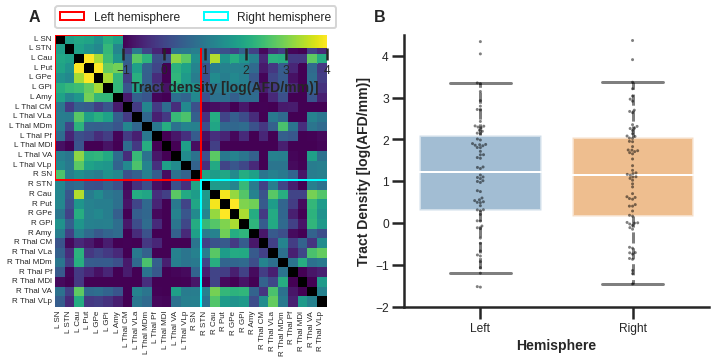

In [73]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

fig = plt.figure(figsize=(12, 5))

fontsize = 12
scatsize = 12
boxsize = 3

# Main gridspec (1 rows, 1 column)
gs_parent = gridspec.GridSpec(1, 1, figure=fig, hspace=.2)
gs_main = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_parent[0])
ax0_left = fig.add_subplot(gs_main[0])
ax0_right = fig.add_subplot(gs_main[1])

cax = inset_axes(ax0_left,
                 width="75%",  # width: 40% parent_bbox width
                 height="5%",  # height: 10% parent_bbox height
                 bbox_transform=ax0_left.transAxes,
                 borderpad=0,
                 )


# Test / Retest Connectivity matrices - ax0
sns.heatmap(
    np.log10(df_hcpur_avg_subconn),
    ax=ax0_left,
    cmap="viridis",
    vmin=-1,
    vmax=4,
    square=True,
    cbar_ax=cax,
    cbar_kws={"orientation": "horizontal", 
              "label": "Tract density [log(AFD/mm)]"}
)

# Add patches to delineate different connectivity
left_hemi = ax0_left.add_patch(Rectangle((0, 0), 15, 15,
                    edgecolor="#ff0000",
                    facecolor="none",
                    lw=2))
right_hemi = ax0_left.add_patch(Rectangle((15, 15), 15, 15,
                   edgecolor="#00ffff",
                   facecolor="none",
                   lw=2))

# Plot params
# ax0_left.set_title("HCP Unrelated")
ax0_left.tick_params(axis="both", length=0)
ax0_left.set_yticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax0_left.set_yticklabels(parcellation_map.reindex(index=reindex_list)["Abbrev"],
                         rotation=0, va="top", ha="right", fontsize=8) 
ax0_left.set_xticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax0_left.set_xticklabels(parcellation_map.reindex(index=reindex_list)["Abbrev"],
                         rotation=90, va="top", ha="left", fontsize=8) 
ax0_left.legend([left_hemi, right_hemi],
                ["Left hemisphere", "Right hemisphere"],
                ncol=2, loc=(0, 1.025))


sns.boxplot(
    data=df_hcp_core,
    x="Hemi",
    y="Density",
    ax=ax0_right,
    dodge=True,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    showfliers=False,
    whis=0.95,
)

sns.swarmplot(
    data=df_hcp_core,
    x="Hemi",
    y="Density",
    ax=ax0_right,
    color="black",
    alpha=0.5,
    dodge=True,
    size=boxsize,
)

ax0_right.set_ylim([-2, 4.5])
ax0_right.spines["right"].set_visible(False)
ax0_right.spines["top"].set_visible(False)
ax0_right.set_ylabel("Tract Density [log(AFD/mm)]")
ax0_right.set_xlabel("Hemisphere")

# Add panel labels
axes = [ax0_left, ax0_right]
for ix, ax in enumerate(axes):
    ax.text(-0.1, 1.05, s=chr(ord("@")+ix+1), fontsize=16, fontweight="bold", transform=ax.transAxes)

        
filename = f"{figure_dir}/fig2.svg"
plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

#### Figure 3
##### Motor circuit

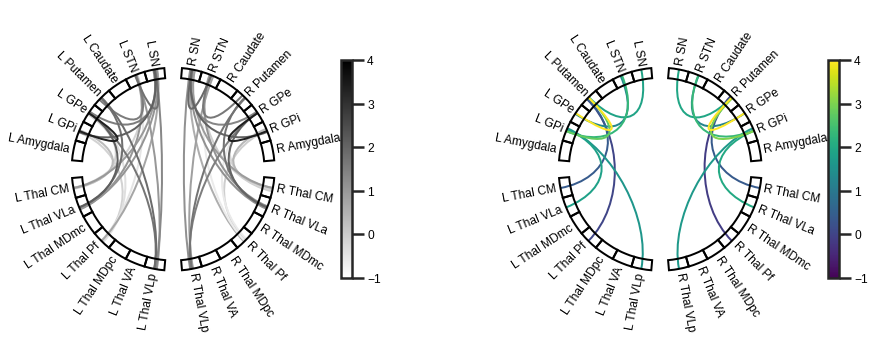

In [9]:
fig = plt.figure(figsize=(16, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 7])

# False connections
plot_chord(motor_mat_density_ur_fp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig,
           subplot=(1,2,1),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="binary",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

# True connections
plot_chord(motor_mat_density_ur_tp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig, 
           subplot=(1,2,2),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

fig.savefig(f"{figure_dir}/motor_circuit_ur.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

##### Associative circuit

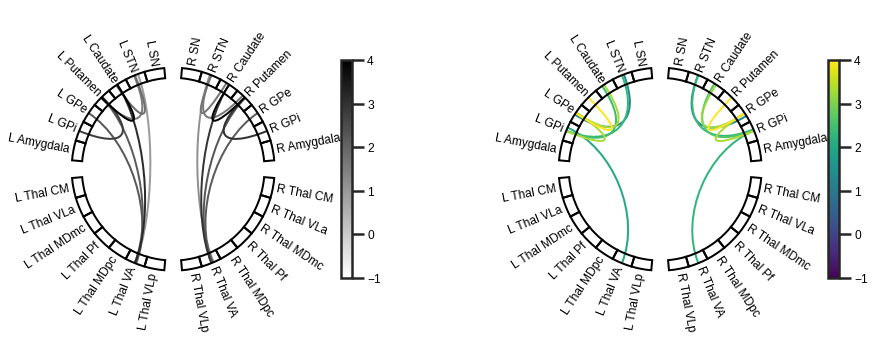

In [15]:
fig = plt.figure(figsize=(16, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 7])

# False connections
plot_chord(assoc_mat_density_ur_fp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig,
           subplot=(1,2,1),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="binary",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

# True connections
plot_chord(assoc_mat_density_ur_tp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig, 
           subplot=(1,2,2),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

fig.savefig(f"{figure_dir}/associative_circuit_hcpur.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

##### Limbic Circuit

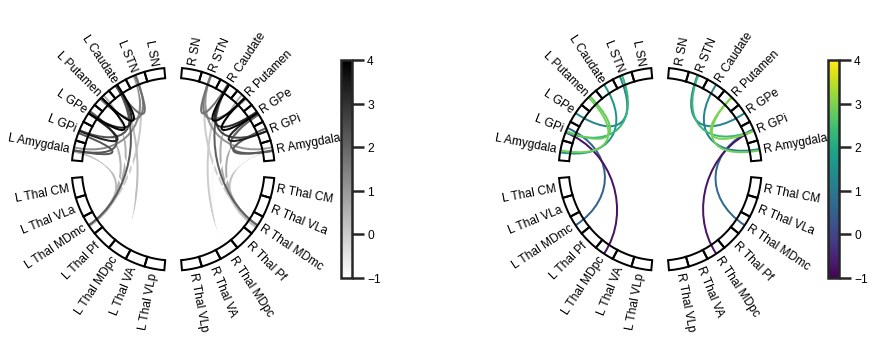

In [24]:
fig = plt.figure(figsize=(16, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 7])

# False connections
plot_chord(limbic_mat_density_ur_fp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig,
           subplot=(1,2,1),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="binary",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

# True connections
plot_chord(limbic_mat_density_ur_tp, 
           final_node_names,
           node_angles=node_angles,
           fig=fig, 
           subplot=(1,2,2),
           colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=2,
           show=False)

fig.savefig(f"{figure_dir}/limbic_circuit_hcpur.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

## Installed Packages <a class="anchor" id="installed_pkgs"></a>

In [28]:
import types

import pkg_resources


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name


imports = list(set(get_imports()))

# Cross-check the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

print("Packages used:")
for r in requirements[::-1]:
    print("{}=={}".format(*r))

Packages used:
dill==0.3.4
dipy==1.4.1
fury==0.6.1
joblib==0.11
matplotlib==3.3.4
nibabel==3.2.1
numpy==1.19.5
pandas==1.0.5
pingouin==0.3.12
scipy==1.4.1
seaborn==0.11.2
tqdm==4.56.2
